In [1]:
from detr_config import Config
from detr_factory import DETRFactory
from detr_file_manager import FileManager
from detr_model_loader import ModelLoader
from detr_data_source import DataSource
import albumentations as A
import numpy as np
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

Config.set_local_settings()

In [2]:
hyperparameters = ('DETR', 100, 6)
detr_factory = DETRFactory(*hyperparameters)
file_manager = FileManager(detr_factory)
model_loader = ModelLoader(detr_factory, file_manager)
data_source = DataSource(detr_factory, file_manager)

file_manager.set_testing_setup()
# model = model_loader.load_best_model()
train_valid_dataset, train_valid_loader = data_source.get_train_valid_dataset_dataloader()
test_dataset, test_loader = data_source.get_test_dataset_dataloader()

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Loading Annotations from:  InBreast_Coco\train_valid\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading Annotations from:  InBreast_Coco\test\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
image, target = test_dataset[0]

In [9]:
target

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.0283, 0.5029, 0.0565, 0.0690]]), 'area': tensor([2495.6387]), 'iscrowd': tensor([0]), 'orig_size': tensor([800, 800])}

In [171]:
image, target = test_dataset[0]
target

[{'id': 0,
  'image_id': 0,
  'category_id': 0,
  'bbox': [710, 283, 53.5, 57],
  'area': 3049.5,
  'segmentation': [],
  'iscrowd': 0}]

In [212]:
transform = A.Compose([
    # A.Normalize(),
    A.PixelDropout(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.2),
    A.Affine(
        scale = (0.8, 1.2),
        translate_percent = {
            'y': (0, 0.2)
        },
        rotate = (-15, 15),
        shear = (-10, 10),
        p = 0.5
    )],
    bbox_params = A.BboxParams(
        format = 'coco',
        label_fields = ['category_ids'],
        min_visibility = 0.25
    )
)

In [213]:
image, annotations = test_dataset[0]
annotations

[{'id': 0,
  'image_id': 0,
  'category_id': 0,
  'bbox': [710, 283, 53.5, 57],
  'area': 3049.5,
  'segmentation': [],
  'iscrowd': 0}]

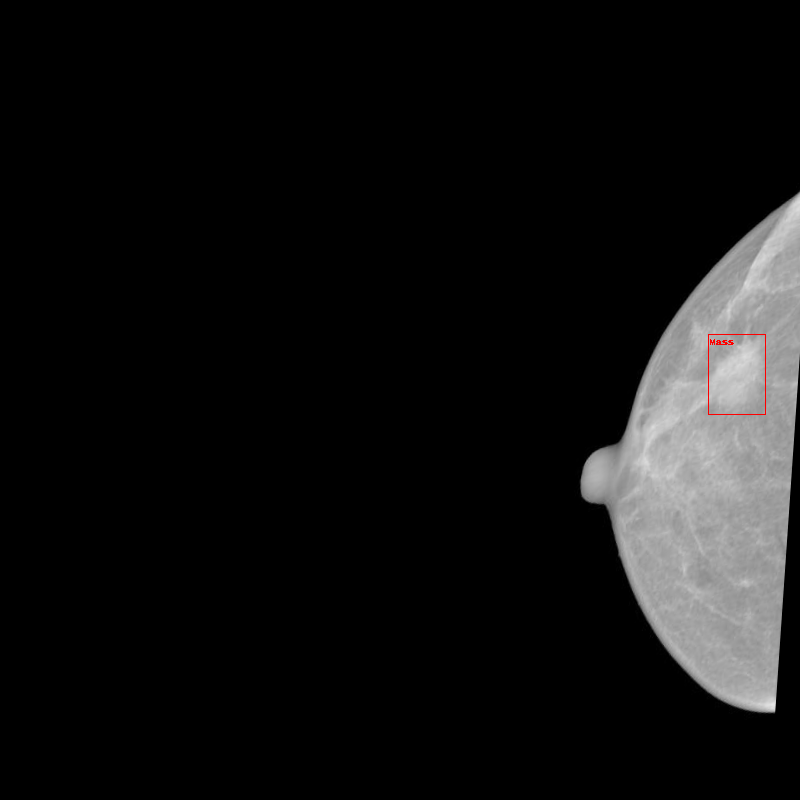

In [214]:
image = np.flip(np.array(image), -1)
bboxes = [ann['bbox'] for ann in annotations]
category_ids = [ann['category_id'] for ann in annotations]

out = transform(
    image = image,
    bboxes = bboxes,
    category_ids = category_ids,
)
# out.keys()

image = torch.tensor(out['image']).flip(-1).permute(2, 0, 1)
if len(out['bboxes']) > 0:
    boxes_xywh = torch.stack([torch.tensor(x) for x in out['bboxes']])
    boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')

    pil_image = to_pil_image(
        draw_bounding_boxes(
            image,
            boxes_xyxy,
            colors='red',
            labels=['Mass']
        )
    )
else:
    pil_image = to_pil_image(image)

pil_image

In [223]:
out.keys()

dict_keys(['image', 'bboxes', 'category_ids'])

In [198]:
target['bbox'] = out['bboxes']

[{'id': 1,
  'image_id': 1,
  'category_id': 0,
  'bbox': [43, 427, 39, 41.5],
  'area': 1618.5,
  'segmentation': [],
  'iscrowd': 0}]

In [194]:
target = {'image_id': target[0]['image_id'], 'annotations': target}
processor = detr_factory.new_image_processor()
encoding = processor(images=image, annotations=target, return_tensors="pt")

In [197]:
encoding["labels"][0]

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.9209, 0.3894, 0.0669, 0.0712]]), 'area': tensor([3049.5000]), 'iscrowd': tensor([0]), 'orig_size': tensor([800, 800])}

In [216]:
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [219]:
encoding['pixel_values'][0].shape

torch.Size([3, 800, 800])